## Indonesian food image to its nutritional content
<b> maaf kalau salah/ngasal, masih pemula </b>

In [2]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.1 MB/s eta 0:00:00


In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from PIL import Image
import os

from sklearn.metrics import classification_report, confusion_matrix
import keras_tuner as kt

In [33]:
# !pip install keras-tuner -q
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [34]:

# # os.listdir('.')
# !unzip './datasets_benar.zip'
# !unzip './train_data.zip'

In [35]:
data_dir = './datasets_benar_coba_upload'
# test_dir = './test_data'

In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory


In [9]:


train_data = image_dataset_from_directory(data_dir, image_size = (224,224), batch_size = 32, label_mode = 'categorical', validation_split=0.2,
                                        subset = 'training', seed=42)

val_data = image_dataset_from_directory(data_dir, image_size = (224,224), batch_size = 32, label_mode = 'categorical', validation_split=0.2,
                                        subset = 'validation', seed=42)



# data = image_dataset_from_directory(data_dir, image_size = (224,224), batch_size = None, label_mode = 'categorical', 
#                                      seed=42)



# test_data = image_dataset_from_directory(test_dir, image_size = (224,224), batch_size = 32, label_mode = 'categorical', seed=42)


Found 11595 files belonging to 58 classes.
Using 9276 files for training.


2024-09-19 23:56:40.908197: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-19 23:56:40.908414: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-19 23:56:40.908510: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Found 11595 files belonging to 58 classes.
Using 2319 files for validation.


In [40]:
from tensorflow.keras.applications import EfficientNetV2S
# BASE_MODEL_PATH =
base_model = EfficientNetV2S(include_top=False, weights='imagenet', classes=58)



82420632/82420632 [==============================] - 1s 0us/step


In [37]:

img_augmentation = tf.keras.models.Sequential(
    [
        tf.keras.layers.RandomRotation(factor=0.40), # 0.4 * 2 * pi
        tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        tf.keras.layers.RandomFlip(),
        tf.keras.layers.RandomContrast(factor=0.1),
        tf.keras.layers.RandomZoom(.5, .4),
        tf.keras.layers.RandomBrightness(factor=0.2)

    ],
    name='img_augmentation'
)

In [38]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_data = train_data.prefetch(buffer_size=AUTOTUNE)

In [41]:
base_model.summary()
base_model.trainable = False


Model: "efficientnetv2-s"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling_1 (Rescaling)     (None, None, None, 3)        0         ['input_2[0][0]']             
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 24)       648       ['rescaling_1[0][0]']         
                                                                                                  
 stem_bn (BatchNormalizatio  (None, None, None, 24)       96        ['stem_conv[0][0]']           
 n)                                                                                

In [11]:
"""

Note: each Keras Application expects a specific kind of input preprocessing. For EfficientNet, input preprocessing is included as part of the model (as a Rescaling layer),
and thus keras.applications.efficientnet.preprocess_input is actually a pass-through function.
EfficientNet models expect their inputs to be float tensors of pixels with values in the [0-255] range.

https://keras.io/api/applications/efficientnet/
"""


'\n\nNote: each Keras Application expects a specific kind of input preprocessing. For EfficientNet, input preprocessing is included as part of the model (as a Rescaling layer),\nand thus keras.applications.efficientnet.preprocess_input is actually a pass-through function.\nEfficientNet models expect their inputs to be float tensors of pixels with values in the [0-255] range.\n\nhttps://keras.io/api/applications/efficientnet/\n'

In [13]:
"""
tf.keras.applications.efficientnet.preprocess_input

The preprocessing logic has been included in the efficientnet model implementation. Users are no longer required to call this method to normalize the input data. This method does nothing and only kept as a placeholder to align the API surface between old and new version of model.
https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet

"""

# EfficientNetV2S
def my_model(units, dropout, lr, batchNorm):

    
    inputs = base_model.input
    x = img_augmentation(inputs)

    x = base_model(x, training=False)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(units=units, activation='relu')(x)
    if batchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
    if dropout:
        x = tf.keras.layers.Dropout(0.2)(x)
    

    outputs =tf.keras.layers.Dense(58, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    model.summary()

    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr),
        loss = tf.keras.losses.CategoricalCrossentropy(),
        metrics = ['accuracy']
    )
    return model




## Hyperparameter Tuning pakai Keras Tuner


In [14]:

def build_model(hp):
    units = hp.Choice("units", [256, 512, 1024])
    dropout = hp.Boolean("dropout")
    lr = hp.Choice("lr", [0.00001, 0.0001, 0.001])
    batchNorm = hp.Boolean("batchNorm")
    model = my_model(
        units=units, dropout=dropout, lr=lr, batchNorm=batchNorm
    )
    return model


In [42]:
cbCheckpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath='model_keras_tuner_batchNorm.{epoch:02d}-{val_loss:.2f}.keras',
        save_best_only=True,
        monitor="val_loss")
cbEvalAcc =   tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", # harusnya val_loss
        patience=3, # harusnya 3
    )

In [16]:
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     project_name='exp_hp_0')


Reloading Tuner from ./exp_hp_0/tuner0.json


In [19]:
tuner_stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)  # harusnya 2,  awalnya 3

In [18]:
# tuner.search(train_data, validation_data=val_data, epochs=15, callbacks=[tuner_stop_early])

Trial 26 Complete [00h 08m 25s]
val_accuracy: 0.7667514681816101

Best val_accuracy So Far: 0.7989822030067444
Total elapsed time: 01h 45m 45s


In [20]:
# !zip -r keras_tuner_neuron1_dropout_lr_batchNorm.zip exp_hp_0

  adding: exp_hp_0/ (stored 0%)
  adding: exp_hp_0/trial_0014/ (stored 0%)
  adding: exp_hp_0/trial_0014/checkpoint.index (deflated 80%)
  adding: exp_hp_0/trial_0014/checkpoint (deflated 48%)
  adding: exp_hp_0/trial_0014/trial.json (deflated 63%)
  adding: exp_hp_0/trial_0014/checkpoint.data-00000-of-00001 (deflated 8%)
  adding: exp_hp_0/trial_0024/ (stored 0%)
  adding: exp_hp_0/trial_0024/checkpoint.index (deflated 80%)
  adding: exp_hp_0/trial_0024/checkpoint (deflated 48%)
  adding: exp_hp_0/trial_0024/trial.json (deflated 64%)
  adding: exp_hp_0/trial_0024/checkpoint.data-00000-of-00001 (deflated 8%)
  adding: exp_hp_0/trial_0012/ (stored 0%)
  adding: exp_hp_0/trial_0012/checkpoint.index (deflated 80%)
  adding: exp_hp_0/trial_0012/checkpoint (deflated 48%)
  adding: exp_hp_0/trial_0012/trial.json (deflated 64%)
  adding: exp_hp_0/trial_0012/checkpoint.data-00000-of-00001 (deflated 8%)
  adding: exp_hp_0/trial_0008/ (stored 0%)
  adding: exp_hp_0/trial_0008/checkpoint.index (d

In [21]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 img_augmentation (Sequenti  (None, None, None, 3)     0         
 al)                                                             
                                                                 
 efficientnetv2-s (Function  (None, None, None, 1280   20331360  
 al)                         )                                   
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                             

In [22]:
# tuner.results_summary()

Results summary
Results in ./exp_hp_0
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0023 summary
Hyperparameters:
units: 256
dropout: True
lr: 0.001
batchNorm: False
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.7989822030067444

Trial 0020 summary
Hyperparameters:
units: 512
dropout: True
lr: 0.001
batchNorm: False
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0016
Score: 0.7900763154029846

Trial 0022 summary
Hyperparameters:
units: 1024
dropout: False
lr: 0.001
batchNorm: False
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.7900763154029846

Trial 0012 summary
Hyperparameters:
units: 512
dropout: False
lr: 0.001
batchNorm: False
tuner/epochs: 4
tuner/initial_epoch: 2
tuner/bracket: 2
tuner/round: 1
tuner/trial_id: 0006
Score: 0.7718405723571777

Trial 0016 summary
Hyperparameters:
units: 512
dropout: True
lr: 0.001
batchNorm: False
tuner/epoc

In [29]:
bestHP = tuner.get_best_hyperparameters(num_trials=1)[0]
print("paling optimal ke 1 dalam 10 epoch")
print("[INFO] jumlah neuron paling optimal pada layer 1: {}".format(
	bestHP.get("units")))
print("[INFO] dropout: {} akan lebih optimal" .format(
	bestHP.get("dropout")))
print("[INFO] batchNorm pada layer 1: {} akan lebih optimal".format(
	bestHP.get("batchNorm")))
print("[INFO] optimal learning rate: {:.4f}".format(
	bestHP.get("lr")))

print("paling optimal ke 2 dalam 10 epoch")
bestHP = tuner.get_best_hyperparameters(num_trials=2)[1]
print("[INFO] jumlah neuron paling optimal pada layer 1: {}".format(
	bestHP.get("units")))
print("[INFO] dropout: {} akan lebih optimal" .format(
	bestHP.get("dropout")))
print("[INFO] batchNorm pada layer 1: {} akan lebih optimal".format(
	bestHP.get("batchNorm")))
print("[INFO] optimal learning rate: {:.4f}".format(
	bestHP.get("lr")))

paling optimal ke 1 dalam 10 epoch
[INFO] jumlah neuron paling optimal pada layer 1: 256
[INFO] dropout: True akan lebih optimal
[INFO] batchNorm pada layer 1: False akan lebih optimal
[INFO] optimal learning rate: 0.0010
paling optimal ke 2 dalam 10 epoch
[INFO] jumlah neuron paling optimal pada layer 1: 512
[INFO] dropout: True akan lebih optimal
[INFO] batchNorm pada layer 1: False akan lebih optimal
[INFO] optimal learning rate: 0.0010


In [31]:

# harus pake gridSearchCV buat batch_size
# train_data_tune = image_dataset_from_directory(data_dir, image_size = (224,224), batch_size = None, label_mode = 'categorical', validation_split=0.2,
#                                         subset = 'training', seed=42)

# val_data_tune = image_dataset_from_directory(data_dir, image_size = (224,224), batch_size = None, label_mode = 'categorical', validation_split=0.2,
#                                         subset = 'validation', seed=42)







Found 11790 files belonging to 58 classes.
Using 9432 files for training.
Found 11790 files belonging to 58 classes.
Using 2358 files for validation.


In [24]:
"""
tuning batchsize,dropout_rate

"""

# EfficientNetV2S
# class MyHyperModel256(kt.HyperModel):
def build_256(dropout_rate):
        


        inputs = base_model.input
        x = img_augmentation(inputs)

        x = base_model(x, training=False)

        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dense(units=256, activation='relu')(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)


        outputs =tf.keras.layers.Dense(58, activation='softmax')(x)
        model = tf.keras.Model(inputs, outputs)
        model.summary()

        model.compile(
            optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
            loss = tf.keras.losses.CategoricalCrossentropy(),
            metrics = ['accuracy']
        )
        return model


    
def build_model(hp):
    dropout_rate = hp.Choice("dropout_rate", [0.2, 0.3, 0.4, 0.5])
    model = build_256(dropout_rate   )
    return model



tuner_256 = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=20,
                     project_name='exp_hp_256_1')



Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 img_augmentation (Sequenti  (None, None, None, 3)     0         
 al)                                                             
                                                                 
 efficientnetv2-s (Function  (None, None, None, 1280   20331360  
 al)                         )                                   
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 256)               327936    
                                                           

In [25]:
tuner_256.search(train_data, validation_data=val_data, epochs=20, callbacks=[tuner_stop_early])

Trial 4 Complete [00h 03m 16s]
val_accuracy: 0.7531806826591492

Best val_accuracy So Far: 0.7616624236106873
Total elapsed time: 00h 11m 40s


In [26]:
tuner_256.results_summary()

Results summary
Results in ./exp_hp_256_1
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0002 summary
Hyperparameters:
dropout_rate: 0.2
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.7616624236106873

Trial 0001 summary
Hyperparameters:
dropout_rate: 0.3
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.7536047697067261

Trial 0003 summary
Hyperparameters:
dropout_rate: 0.5
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.7531806826591492

Trial 0000 summary
Hyperparameters:
dropout_rate: 0.4
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.7510602474212646


In [27]:
bestHP = tuner_256.get_best_hyperparameters(num_trials=1)[0]
print("paling optimal ke 1 dalam 10 epoch")

print("[INFO] dropout: {} akan lebih optimal" .format(
	bestHP.get("dropout_rate")))


print("paling optimal ke 2 dalam 10 epoch")
bestHP = tuner_256.get_best_hyperparameters(num_trials=2)[1]

print("[INFO] dropout: {} akan lebih optimal" .format(
	bestHP.get("dropout_rate")))


paling optimal ke 1 dalam 10 epoch
[INFO] dropout: 0.2 akan lebih optimal
paling optimal ke 2 dalam 10 epoch
[INFO] dropout: 0.3 akan lebih optimal


In [28]:
"""
tuning batchsize,dropout_rate

"""

# EfficientNetV2S
# class MyHyperModel256(kt.HyperModel):
def build_512(dropout_rate):
        


        inputs = base_model.input
        x = img_augmentation(inputs)

        x = base_model(x, training=False)

        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dense(units=512, activation='relu')(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)


        outputs =tf.keras.layers.Dense(58, activation='softmax')(x)
        model = tf.keras.Model(inputs, outputs)
        model.summary()

        model.compile(
            optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
            loss = tf.keras.losses.CategoricalCrossentropy(),
            metrics = ['accuracy']
        )
        return model


    
def build_model_512(hp):
    dropout_rate = hp.Choice("dropout_rate", [0.2, 0.3, 0.4, 0.5])
    model = build_512(dropout_rate   )
    return model



tuner_512 = kt.Hyperband(build_model_512,
                     objective='val_accuracy',
                     max_epochs=20,
                     project_name='exp_hp_512_1')



Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 img_augmentation (Sequenti  (None, None, None, 3)     0         
 al)                                                             
                                                                 
 efficientnetv2-s (Function  (None, None, None, 1280   20331360  
 al)                         )                                   
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 512)               655872    
                                                           

In [30]:
tuner_512.search(train_data, validation_data=val_data, epochs=20, callbacks=[tuner_stop_early])

Trial 4 Complete [00h 02m 41s]
val_accuracy: 0.7650551199913025

Best val_accuracy So Far: 0.7782018780708313
Total elapsed time: 00h 11m 20s


In [32]:
bestHP = tuner_512.get_best_hyperparameters(num_trials=1)[0]
print("paling optimal ke 1 dalam 10 epoch")

print("[INFO] dropout: {} akan lebih optimal" .format(
	bestHP.get("dropout_rate")))


print("paling optimal ke 2 dalam 10 epoch")
bestHP = tuner_512.get_best_hyperparameters(num_trials=2)[1]

print("[INFO] dropout: {} akan lebih optimal" .format(
	bestHP.get("dropout_rate")))


paling optimal ke 1 dalam 10 epoch
[INFO] dropout: 0.2 akan lebih optimal
paling optimal ke 2 dalam 10 epoch
[INFO] dropout: 0.3 akan lebih optimal


In [61]:
"""
tuning batch size 16,32,64
"""

train_data_sixteen = image_dataset_from_directory(data_dir, image_size = (224,224), batch_size = 16, label_mode = 'categorical', validation_split=0.2,
                                        subset = 'training', seed=42)

val_data_sixteen = image_dataset_from_directory(data_dir, image_size = (224,224), batch_size = 16, label_mode = 'categorical', validation_split=0.2,
                                        subset = 'validation', seed=42)

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_data_sixteen = train_data_sixteen.prefetch(buffer_size=AUTOTUNE)

Found 11595 files belonging to 58 classes.
Using 9276 files for training.
Found 11595 files belonging to 58 classes.
Using 2319 files for validation.


In [23]:
def best_model():
        inputs = base_model.input
        x = img_augmentation(inputs)

        x = base_model(x, training=False)

        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dense(units=512, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.2)(x)


        outputs =tf.keras.layers.Dense(58, activation='softmax')(x)
        model = tf.keras.Model(inputs, outputs)
        model.summary()

        model.compile(
            optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
            loss = tf.keras.losses.CategoricalCrossentropy(),
            metrics = ['accuracy']
        )
        return model
    
model_sixteen = best_model()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 img_augmentation (Sequenti  (None, None, None, 3)     0         
 al)                                                             
                                                                 
 efficientnetv2-s (Function  (None, None, None, 1280   20331360  
 al)                         )                                   
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                             

In [44]:
start = time.time()


hist = model_sixteen.fit(train_data_sixteen, epochs=25, validation_data=val_data_sixteen, verbose=1, callbacks=[cbEvalAcc, cbCheckpoint])

end = time.time()
print("The time of execution of above program is :",
      (end-start), "s")

Epoch 1/25
112/590 [====>.........................] - ETA: 36s - loss: 1.1029 - accuracy: 0.6908

2024-09-18 11:20:21.586493: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


374/590 [==================>...........] - ETA: 15s - loss: 1.0977 - accuracy: 0.6870

2024-09-18 11:20:40.711000: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


459/590 [======================>.......] - ETA: 9s - loss: 1.0904 - accuracy: 0.6875

2024-09-18 11:20:46.823668: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-09-18 11:20:46.823777: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


590/590 [==============================] - ETA: 0s - loss: 1.0863 - accuracy: 0.6871

2024-09-18 11:21:01.551026: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-09-18 11:21:06.903373: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


590/590 [==============================] - 64s 108ms/step - loss: 1.0863 - accuracy: 0.6871 - val_loss: 0.8553 - val_accuracy: 0.7375
Epoch 2/25
111/590 [====>.........................] - ETA: 36s - loss: 0.9301 - accuracy: 0.7331

2024-09-18 11:21:25.738925: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


374/590 [==================>...........] - ETA: 15s - loss: 0.9058 - accuracy: 0.7303

2024-09-18 11:21:44.503143: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


460/590 [======================>.......] - ETA: 9s - loss: 0.9084 - accuracy: 0.7291

2024-09-18 11:21:50.722309: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-09-18 11:21:50.722375: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


589/590 [============================>.] - ETA: 0s - loss: 0.9093 - accuracy: 0.7280

2024-09-18 11:22:00.529975: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-09-18 11:22:05.638698: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


590/590 [==============================] - 55s 93ms/step - loss: 0.9089 - accuracy: 0.7282 - val_loss: 0.8347 - val_accuracy: 0.7464
Epoch 3/25
112/590 [====>.........................] - ETA: 35s - loss: 0.8416 - accuracy: 0.7394

2024-09-18 11:22:20.485531: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


374/590 [==================>...........] - ETA: 15s - loss: 0.8223 - accuracy: 0.7490

2024-09-18 11:22:39.484261: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


459/590 [======================>.......] - ETA: 9s - loss: 0.8145 - accuracy: 0.7512

2024-09-18 11:22:45.686500: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-09-18 11:22:45.686601: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


589/590 [============================>.] - ETA: 0s - loss: 0.8155 - accuracy: 0.7502

2024-09-18 11:22:55.510848: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-09-18 11:23:00.642819: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


590/590 [==============================] - 55s 93ms/step - loss: 0.8162 - accuracy: 0.7500 - val_loss: 0.7900 - val_accuracy: 0.7651
Epoch 4/25
112/590 [====>.........................] - ETA: 33s - loss: 0.7306 - accuracy: 0.7734

2024-09-18 11:23:41.985347: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


374/590 [==================>...........] - ETA: 15s - loss: 0.7581 - accuracy: 0.7657

2024-09-18 11:24:00.758904: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


460/590 [======================>.......] - ETA: 9s - loss: 0.7535 - accuracy: 0.7689

2024-09-18 11:24:06.988532: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-09-18 11:24:06.988626: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


589/590 [============================>.] - ETA: 0s - loss: 0.7458 - accuracy: 0.7701

2024-09-18 11:24:16.490086: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-09-18 11:24:21.823335: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


590/590 [==============================] - 52s 87ms/step - loss: 0.7456 - accuracy: 0.7701 - val_loss: 0.8128 - val_accuracy: 0.7663
Epoch 5/25
112/590 [====>.........................] - ETA: 33s - loss: 0.6949 - accuracy: 0.7835

2024-09-18 11:24:33.825490: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


374/590 [==================>...........] - ETA: 15s - loss: 0.7126 - accuracy: 0.7846

2024-09-18 11:24:52.777312: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


459/590 [======================>.......] - ETA: 9s - loss: 0.7039 - accuracy: 0.7876

2024-09-18 11:24:59.126654: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-09-18 11:24:59.127346: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


589/590 [============================>.] - ETA: 0s - loss: 0.6991 - accuracy: 0.7866

2024-09-18 11:25:09.228744: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-09-18 11:25:14.503561: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


590/590 [==============================] - 55s 93ms/step - loss: 0.6995 - accuracy: 0.7863 - val_loss: 0.7609 - val_accuracy: 0.7820
Epoch 6/25
111/590 [====>.........................] - ETA: 34s - loss: 0.6749 - accuracy: 0.7872

2024-09-18 11:25:29.132331: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


374/590 [==================>...........] - ETA: 15s - loss: 0.6661 - accuracy: 0.7888

2024-09-18 11:25:48.127544: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


460/590 [======================>.......] - ETA: 9s - loss: 0.6594 - accuracy: 0.7910

2024-09-18 11:25:54.257036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-09-18 11:25:54.257113: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


589/590 [============================>.] - ETA: 0s - loss: 0.6579 - accuracy: 0.7911

2024-09-18 11:26:03.540592: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-09-18 11:26:08.856767: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


590/590 [==============================] - 52s 88ms/step - loss: 0.6589 - accuracy: 0.7909 - val_loss: 0.7771 - val_accuracy: 0.7782
Epoch 7/25
112/590 [====>.........................] - ETA: 36s - loss: 0.6391 - accuracy: 0.7974

2024-09-18 11:26:21.652041: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


374/590 [==================>...........] - ETA: 16s - loss: 0.6339 - accuracy: 0.7998

2024-09-18 11:26:41.063724: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


460/590 [======================>.......] - ETA: 9s - loss: 0.6401 - accuracy: 0.7984

2024-09-18 11:26:46.941567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-09-18 11:26:46.941633: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


589/590 [============================>.] - ETA: 0s - loss: 0.6315 - accuracy: 0.7992

2024-09-18 11:26:56.901696: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-09-18 11:27:01.885919: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


590/590 [==============================] - 53s 89ms/step - loss: 0.6326 - accuracy: 0.7990 - val_loss: 0.7736 - val_accuracy: 0.7875
Epoch 8/25
112/590 [====>.........................] - ETA: 33s - loss: 0.5491 - accuracy: 0.8248

2024-09-18 11:27:14.007350: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


374/590 [==================>...........] - ETA: 15s - loss: 0.5994 - accuracy: 0.8088

2024-09-18 11:27:32.163244: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


459/590 [======================>.......] - ETA: 9s - loss: 0.5981 - accuracy: 0.8095

2024-09-18 11:27:38.353788: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-09-18 11:27:38.353899: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


589/590 [============================>.] - ETA: 0s - loss: 0.5973 - accuracy: 0.8104

2024-09-18 11:27:48.002419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-09-18 11:27:53.147044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


590/590 [==============================] - 53s 90ms/step - loss: 0.5971 - accuracy: 0.8104 - val_loss: 0.7488 - val_accuracy: 0.7892
Epoch 9/25
112/590 [====>.........................] - ETA: 33s - loss: 0.5699 - accuracy: 0.8265

2024-09-18 11:28:35.879874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


373/590 [=================>............] - ETA: 14s - loss: 0.5756 - accuracy: 0.8197

2024-09-18 11:28:53.777396: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


460/590 [======================>.......] - ETA: 9s - loss: 0.5777 - accuracy: 0.8205

2024-09-18 11:29:00.092349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-09-18 11:29:00.092929: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


589/590 [============================>.] - ETA: 0s - loss: 0.5791 - accuracy: 0.8191

2024-09-18 11:29:10.077792: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-09-18 11:29:15.506469: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


590/590 [==============================] - 52s 88ms/step - loss: 0.5794 - accuracy: 0.8191 - val_loss: 0.7833 - val_accuracy: 0.7892
Epoch 10/25
112/590 [====>.........................] - ETA: 35s - loss: 0.5438 - accuracy: 0.8203

2024-09-18 11:29:28.132895: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


374/590 [==================>...........] - ETA: 15s - loss: 0.5558 - accuracy: 0.8194

2024-09-18 11:29:46.124758: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


460/590 [======================>.......] - ETA: 9s - loss: 0.5529 - accuracy: 0.8197

2024-09-18 11:29:52.037969: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-09-18 11:29:52.038055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


589/590 [============================>.] - ETA: 0s - loss: 0.5457 - accuracy: 0.8225

2024-09-18 11:30:01.656810: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-09-18 11:30:07.011389: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


590/590 [==============================] - 51s 87ms/step - loss: 0.5455 - accuracy: 0.8225 - val_loss: 0.8474 - val_accuracy: 0.7727
Epoch 11/25
112/590 [====>.........................] - ETA: 36s - loss: 0.5252 - accuracy: 0.8309

2024-09-18 11:30:19.910029: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


374/590 [==================>...........] - ETA: 15s - loss: 0.5390 - accuracy: 0.8292

2024-09-18 11:30:39.010645: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


460/590 [======================>.......] - ETA: 9s - loss: 0.5367 - accuracy: 0.8291

2024-09-18 11:30:45.553366: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-09-18 11:30:45.553442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


589/590 [============================>.] - ETA: 0s - loss: 0.5292 - accuracy: 0.8319

2024-09-18 11:30:55.332885: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-09-18 11:31:00.430072: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


590/590 [==============================] - 54s 91ms/step - loss: 0.5288 - accuracy: 0.8321 - val_loss: 0.7569 - val_accuracy: 0.7947
The time of execution of above program is : 652.2923645973206 s


In [43]:
def save_plot_loss(H, path):
    print("min val_loss: ", min(H.history["val_loss"]))
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(H.history["loss"], label="train_loss")
    plt.plot(H.history["val_loss"], label="val_loss")

    plt.title("Training Loss ")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(path)

    
def save_plot_acc(H, path):
    print("max val_accuracy: " , max(H.history["val_accuracy"]))
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(H.history["accuracy"], label="train_acc")
    plt.plot(H.history["val_accuracy"], label="val_acc")
    plt.title(" Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig(path)

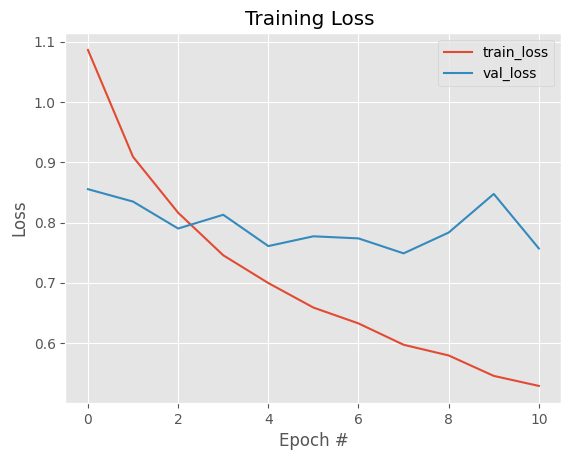

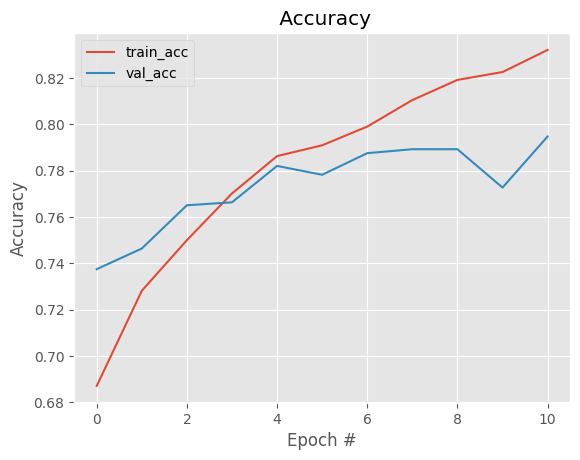

In [50]:
save_plot_loss(hist, "sixteen_batch_size_512_loss")
save_plot_acc(hist,  "sixteen_batch_size_512_acc")

In [44]:
"""
tuning batch size 16,32,64
"""

train_data_thirtytwo = image_dataset_from_directory(data_dir, image_size = (224,224), batch_size = 32, label_mode = 'categorical', validation_split=0.20,
                                        subset = 'training', seed=42)

val_data_thirtytwo = image_dataset_from_directory(data_dir, image_size = (224,224), batch_size = 32, label_mode = 'categorical', validation_split=0.20,
                                        subset = 'validation', seed=42)

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_data_thirtytwo = train_data_thirtytwo.prefetch(buffer_size=AUTOTUNE)

Found 11595 files belonging to 58 classes.
Using 9276 files for training.
Found 11595 files belonging to 58 classes.
Using 2319 files for validation.


In [33]:
cbCheckpointthirtyTwo = tf.keras.callbacks.ModelCheckpoint(
        filepath='model_keras_tuner_batchNorm_512_32.{epoch:02d}-{val_loss:.2f}.keras',
        save_best_only=True,
        monitor="val_loss")


In [54]:
start = time.time()

model_thiryTwo = best_model()
hist_thirty_two = model_thiryTwo.fit(train_data_thirtytwo, epochs=25, validation_data=val_data_thirtytwo, verbose=1, callbacks=[cbEvalAcc, cbCheckpointthirtyTwo])

end = time.time()
print("The time of execution of above program is :",
      (end-start), "s")

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 img_augmentation (Sequenti  (None, None, None, 3)     0         
 al)                                                             
                                                                 
 efficientnetv2-s (Function  (None, None, None, 1280   20331360  
 al)                         )                                   
                                                                 
 global_average_pooling2d_8  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_16 (Dense)            (None, 512)               655872    
                                                           

min val_loss:  0.6907811164855957
max val_accuracy:  0.8025010824203491


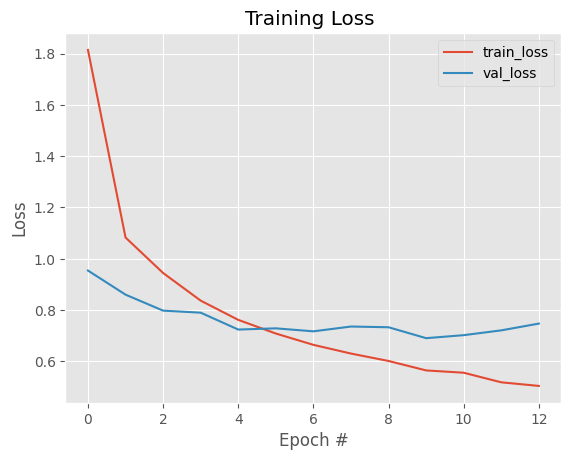

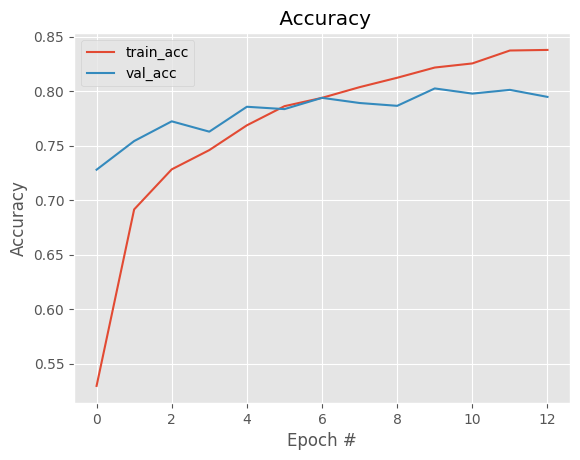

In [55]:
save_plot_loss(hist_thirty_two, "thirtytwo_batch_size_512_loss")
save_plot_acc(hist_thirty_two,  "thirtytwo_batch_size_512_acc")

In [49]:
# weight decay, & momentum tuning




In [59]:
start = time.time()
cbCheckpointthirtyTwoLrDecay = tf.keras.callbacks.ModelCheckpoint(
        filepath='model_keras_tuner_batchNorm_512_32_lrdc.{epoch:02d}-{val_loss:.2f}.keras',
        save_best_only=True,
        monitor="val_loss")

model_thiryTwo = best_model()
hist_thirty_two = model_thiryTwo.fit(train_data_thirtytwo, epochs=epochs, validation_data=val_data_thirtytwo, verbose=1, callbacks=[cbEvalAcc, cbCheckpointthirtyTwoLrDecay])

end = time.time()
print("The time of execution of above program is :",
      (end-start), "s")

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 img_augmentation (Sequenti  (None, None, None, 3)     0         
 al)                                                             
                                                                 
 efficientnetv2-s (Function  (None, None, None, 1280   20331360  
 al)                         )                                   
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
 0 (GlobalAveragePooling2D)                                      
                                                                 
 dense_20 (Dense)            (None, 512)               655872    
                                                          

min val_loss:  0.6755418181419373
max val_accuracy:  0.8033635020256042


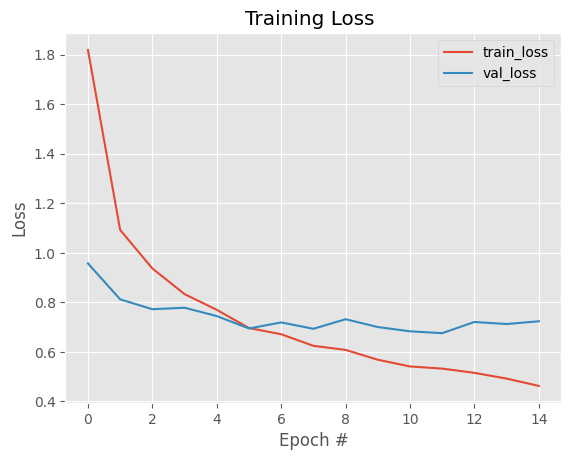

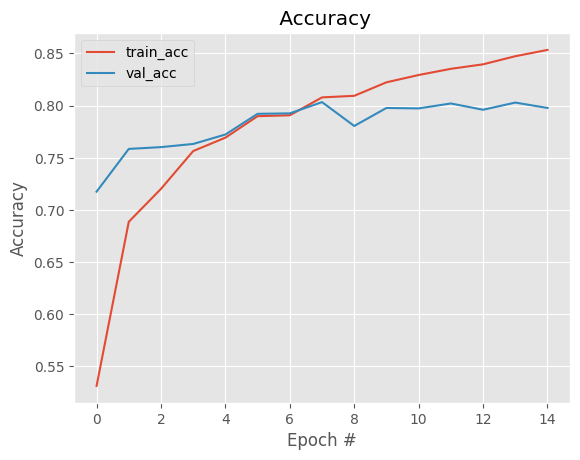

In [60]:
save_plot_loss(hist_thirty_two, "thirtytwo_batch_size_512_loss_lr_decay")
save_plot_acc(hist_thirty_two,  "thirtytwo_batch_size_512_acc_lr_decay")

In [13]:
# start = time.time()
# cbCheckpointthirtyTwoLrDecay = tf.keras.callbacks.ModelCheckpoint(
#         filepath='model_keras_tuner_batchNorm_512_32_lrdc_pointthree.{epoch:02d}-{val_loss:.2f}.keras',
#         save_best_only=True,
#         monitor="val_loss")

# model_thiryTwo = best_model()
# hist_thirty_two = model_thiryTwo.fit(train_data_thirtytwo, epochs=epochs, validation_data=val_data_thirtytwo, verbose=1, callbacks=[cbEvalAcc, cbCheckpointthirtyTwoLrDecay])

# end = time.time()
# print("The time of execution of above program is :",
#       (end-start), "s")

In [17]:
"""
 lr,  & weight decay tuning

"""
from keras.regularizers import l2


def build_512(use_ema, weight_decay, learning_rate, dense ):
        
        inputs = base_model.input
        x = img_augmentation(inputs)

        x = base_model(x, training=False)

        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        if dense:
            if weight_decay:
                x = tf.keras.layers.Dense(units=512, activation='relu', kernel_regularizer=l2(0.0005))(x)
            else:
                x = tf.keras.layers.Dense(units=512, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.2)(x)

        outputs =tf.keras.layers.Dense(58, activation='softmax')(x)
        model = tf.keras.Model(inputs, outputs)
        model.summary()
        
        optimizer =  tf.keras.optimizers.Adam(learning_rate=learning_rate)
        
        if use_ema:
            optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, use_ema=True) 
            
        model.compile(
            optimizer = optimizer,
            loss = tf.keras.losses.CategoricalCrossentropy(),
            metrics = ['accuracy']
        )
        return model


    
def build_model_512(hp):
    use_ema = hp.Boolean("use_ema")
    weight_decay = hp.Boolean("weight_decay")
    learning_rate = hp.Choice("lr", [0.0001, 0.0003, 0.0005, 0.00005])
    dense = hp.Boolean("dense")
    model = build_512(use_ema, weight_decay, learning_rate,  dense  )
    return model



tuner_512_decay_momentum = kt.Hyperband(build_model_512,
                     objective='val_accuracy',
                     max_epochs=30,

                     project_name='exp_hp_512_lr_momen_dc-3')



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 img_augmentation (Sequenti  (None, None, None, 3)     0         
 al)                                                             
                                                                 
 efficientnetv2-s (Function  (None, None, None, 1280   20331360  
 al)                         )                                   
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                             

In [21]:
tuner_512_decay_momentum.search(train_data_thirtytwo, validation_data=val_data_thirtytwo, epochs=50, callbacks=[tuner_stop_early])

Trial 31 Complete [00h 01m 33s]
val_accuracy: 0.6360500454902649

Best val_accuracy So Far: 0.7615351676940918
Total elapsed time: 00h 48m 13s


In [28]:
tuner_512_decay_momentum.results_summary()


Results summary
Results in ./exp_hp_512_lr_momen_dc-3
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0000 summary
Hyperparameters:
use_ema: True
weight_decay: False
lr: 0.0005
dense: True
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0
Score: 0.7615351676940918

Trial 0014 summary
Hyperparameters:
use_ema: False
weight_decay: True
lr: 0.0005
dense: True
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0
Score: 0.7593790292739868

Trial 0017 summary
Hyperparameters:
use_ema: False
weight_decay: False
lr: 0.0005
dense: True
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0
Score: 0.7567917108535767

Trial 0010 summary
Hyperparameters:
use_ema: True
weight_decay: True
lr: 0.0003
dense: True
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0
Score: 0.7378180027008057

Trial 0003 summary
Hyperparameters:
use_ema: True
weight_decay: False
lr: 0.0003
dense: True
tuner/epochs: 2
t

In [25]:
bestHP = tuner_512_decay_momentum.get_best_hyperparameters(num_trials=1)[0]
print("paling optimal ke 1 dalam 10 epoch")

print("[INFO] use_ema: {} akan lebih optimal" .format(
	bestHP.get("use_ema")))
print("[INFO] weight_decay: {} akan lebih optimal" .format(
	bestHP.get("weight_decay")))

print("[INFO] dense/tidak pakai dense: {} akan lebih optimal" .format(
	bestHP.get("dense")))
print("[INFO] lr: {} akan lebih optimal" .format(
	bestHP.get("lr")))


print("paling optimal ke 2 dalam 10 epoch")
bestHP = tuner_512_decay_momentum.get_best_hyperparameters(num_trials=2)[1]

print("[INFO] weight_decay: {} akan lebih optimal" .format(
	bestHP.get("weight_decay")))
print("[INFO] use_ema: {} akan lebih optimal" .format(
	bestHP.get("use_ema")))



print("[INFO] dense/tidak pakai dense: {} akan lebih optimal" .format(
	bestHP.get("dense")))
print("[INFO] lr: {} akan lebih optimal" .format(
	bestHP.get("lr")))



paling optimal ke 1 dalam 10 epoch
[INFO] use_ema: True akan lebih optimal
[INFO] weight_decay: False akan lebih optimal
[INFO] dense/tidak pakai dense: True akan lebih optimal
[INFO] lr: 0.0005 akan lebih optimal
paling optimal ke 2 dalam 10 epoch
[INFO] weight_decay: True akan lebih optimal
[INFO] use_ema: False akan lebih optimal
[INFO] dense/tidak pakai dense: True akan lebih optimal
[INFO] lr: 0.0005 akan lebih optimal


In [49]:
from keras.callbacks import LearningRateScheduler

epochs=50
learning_rate = 0.0005



def best_model_EffS():
        inputs = base_model.input
        x = img_augmentation(inputs)

        x = base_model(x, training=False)

        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dense(units=512, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.2)(x)


        outputs =tf.keras.layers.Dense(58, activation='softmax')(x)
        model = tf.keras.Model(inputs, outputs)
        model.summary()

        model.compile(
            optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),
            loss = tf.keras.losses.CategoricalCrossentropy(),
            metrics = ['accuracy']
        )
        return model

In [35]:
start = time.time()
cbCheckpointthirtyTwoLrDecay = tf.keras.callbacks.ModelCheckpoint(
        filepath='model_keras_tuner_batchNorm_512_32_EffS.{epoch:02d}-{val_loss:.2f}.keras',
        save_best_only=True,
        monitor="val_loss")

model_Effs_best = best_model_EffS()

hist_thirty_two = model_Effs_best.fit(train_data_thirtytwo, epochs=epochs, validation_data=val_data_thirtytwo, verbose=1, callbacks=[cbEvalAcc, cbCheckpointthirtyTwoLrDecay])

end = time.time()
print("The time of execution of above program is :",
      (end-start), "s")

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 img_augmentation (Sequenti  (None, None, None, 3)     0         
 al)                                                             
                                                                 
 efficientnetv2-s (Function  (None, None, None, 1280   20331360  
 al)                         )                                   
                                                                 
 global_average_pooling2d_3  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 512)               655872    
                                                           

min val_loss:  0.6093243360519409
max val_accuracy:  0.8206123113632202


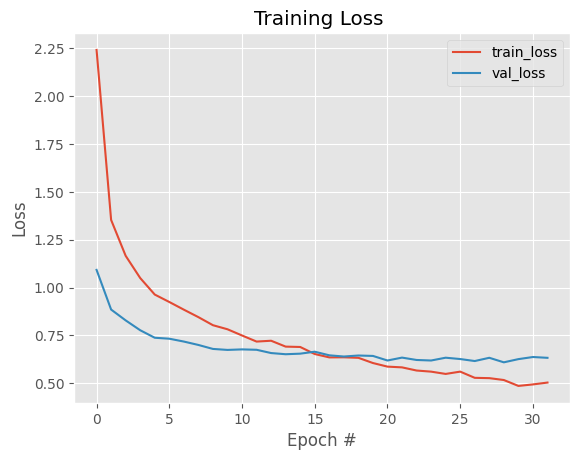

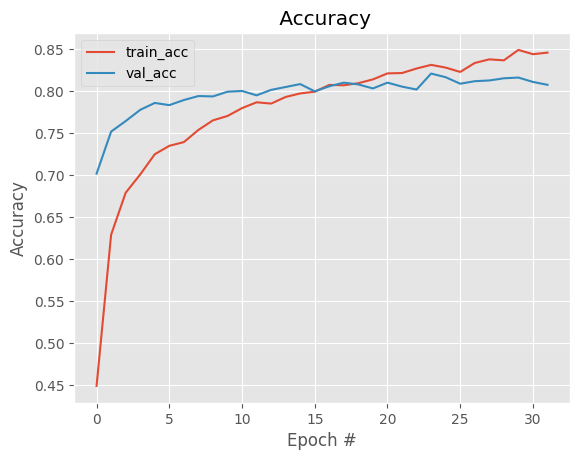

In [39]:
save_plot_loss(hist_thirty_two, "thirtytwo_batch_size_512_loss_effS")
save_plot_acc(hist_thirty_two,  "thirtytwo_batch_size_512_acc_effS")

In [16]:
from tensorflow.keras.applications import EfficientNetV2M
# BASE_MODEL_PATH 
base_model_M = EfficientNetV2M(include_top=False, weights='imagenet', classes=58)
base_model_M.summary()
base_model_M.trainable = False

214201816/214201816 [==============================] - 2s 0us/step
Model: "efficientnetv2-m"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 24)       648       ['rescaling[0][0]']           
                                                                                                  
 stem_bn (BatchNormalizatio  (None, None, None, 24)       96        ['stem_conv[0][0]']           
 n)             

In [19]:



cbEvalAccM =   tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=3,
    )


def best_model_EffM():
        inputs = base_model_M.input
        x = img_augmentation(inputs)

        x = base_model_M(x, training=False)

        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dense(units=512, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.2)(x)


        outputs =tf.keras.layers.Dense(58, activation='softmax')(x)
        model = tf.keras.Model(inputs, outputs)
        model.summary()

        model.compile(
            optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005),
            loss = tf.keras.losses.CategoricalCrossentropy(),
            metrics = ['accuracy']
        )
        return model

In [20]:
start = time.time()
cbCheckpointBestM = tf.keras.callbacks.ModelCheckpoint(
        filepath='model_keras_tuner_batchNorm_512_32_EffM.{epoch:02d}-{val_loss:.2f}.keras',
        save_best_only=True,
        monitor="val_loss")

model_EffM_best = best_model_EffM()

hist_effM = model_EffM_best.fit(train_data_thirtytwo, epochs=epochs, validation_data=val_data_thirtytwo, verbose=1, callbacks=[cbEvalAccM, cbCheckpointBestM])
# 0.8083
end = time.time()
print("The time of execution of above program is :",
      (end-start), "s")

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 img_augmentation (Sequenti  (None, None, None, 3)     0         
 al)                                                             
                                                                 
 efficientnetv2-m (Function  (None, None, None, 1280   53150388  
 al)                         )                                   
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 512)               655872    
                                                           

min val_loss:  0.7141603827476501
max val_accuracy:  0.7938766479492188


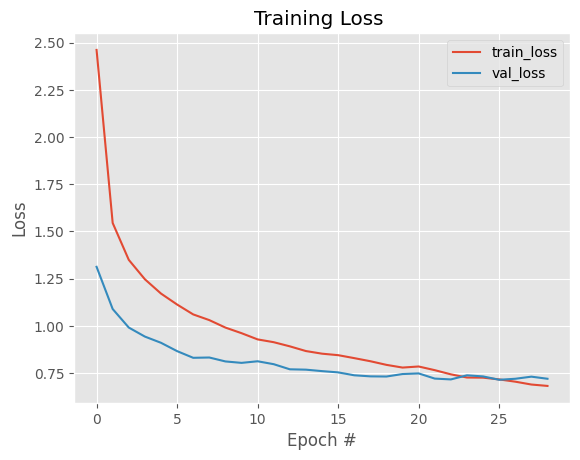

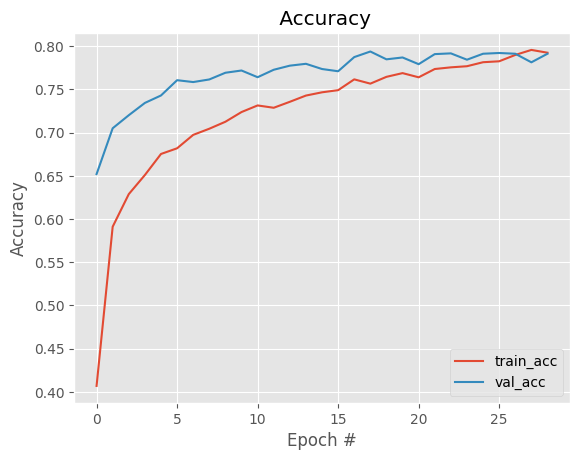

In [21]:
save_plot_loss(hist_effM, "thirtytwo_batch_size_512_loss_effM")
save_plot_acc(hist_effM,  "thirtytwo_batch_size_512_acc_effM")

In [23]:



cbEvalAccM =   tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=3,
    )


def best_model_EffM():
        inputs = base_model_M.input
        x = img_augmentation(inputs)

        x = base_model_M(x, training=False)

        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dense(units=512, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.2)(x)


        outputs =tf.keras.layers.Dense(58, activation='softmax')(x)
        model = tf.keras.Model(inputs, outputs)
        model.summary()

        model.compile(
            optimizer = tf.keras.optimizers.Adam(),
            loss = tf.keras.losses.CategoricalCrossentropy(),
            metrics = ['accuracy']
        )
        return model

In [24]:
start = time.time()
cbCheckpointBestM = tf.keras.callbacks.ModelCheckpoint(
        filepath='model_keras_tuner_batchNorm_512_32_EffM.{epoch:02d}-{val_loss:.2f}.keras',
        save_best_only=True,
        monitor="val_loss")

model_EffM_best = best_model_EffM()

hist_effM = model_EffM_best.fit(train_data_thirtytwo, epochs=epochs, validation_data=val_data_thirtytwo, verbose=1, callbacks=[cbEvalAccM, cbCheckpointBestM])
# 0.8083
end = time.time()
print("The time of execution of above program is :",
      (end-start), "s")

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 img_augmentation (Sequenti  (None, None, None, 3)     0         
 al)                                                             
                                                                 
 efficientnetv2-m (Function  (None, None, None, 1280   53150388  
 al)                         )                                   
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 512)               655872    
                                                           

min val_loss:  0.7515817880630493
max val_accuracy:  0.7904269099235535


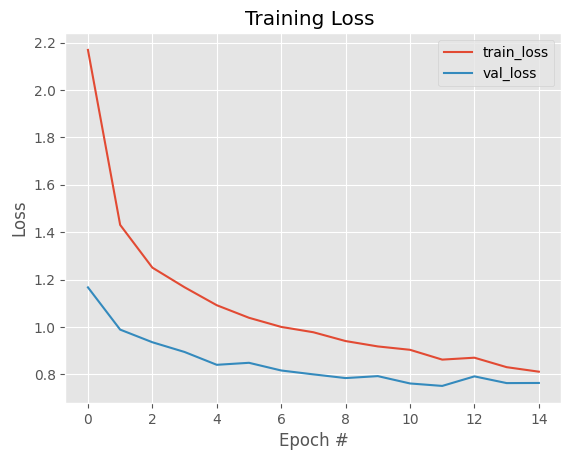

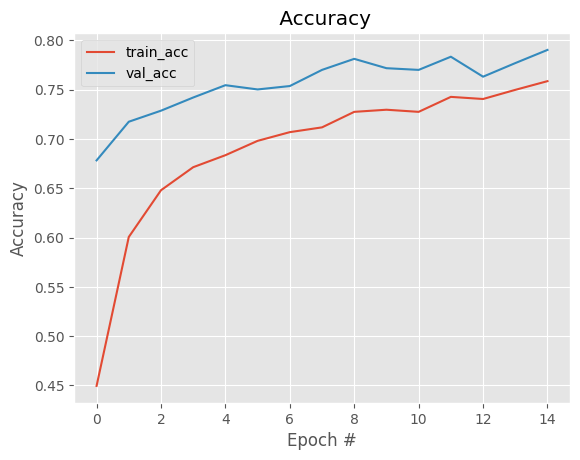

In [25]:
save_plot_loss(hist_effM, "thirtytwo_batch_size_512_loss_effM")
save_plot_acc(hist_effM,  "thirtytwo_batch_size_512_acc_effM")

In [51]:


epochs=50
cbEvalAccM =   tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5, # ganti 4
    )


def best_model_EffM():
        inputs = base_model_M.input
        x = img_augmentation(inputs)

        x = base_model_M(x, training=False)

        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dense(units=512, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.2)(x)


        outputs =tf.keras.layers.Dense(58, activation='softmax')(x)
        model = tf.keras.Model(inputs, outputs)
        model.summary()

        model.compile(
            optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, use_ema=True),
            loss = tf.keras.losses.CategoricalCrossentropy(),
            metrics = ['accuracy']
        )
        return model

In [24]:
start = time.time()
cbCheckpointBestM = tf.keras.callbacks.ModelCheckpoint(
        filepath='model_keras_tuner_batchNorm_512_32_EffM.{epoch:02d}-{val_loss:.2f}.keras',
        save_best_only=True,
        monitor="val_loss")

model_EffM_best = best_model_EffM()

hist_effM = model_EffM_best.fit(train_data_thirtytwo, epochs=epochs, validation_data=val_data_thirtytwo, verbose=1, callbacks=[cbEvalAccM, cbCheckpointBestM])
# 0.8083
# 1024 -> 0.784 val_acc
end = time.time()
print("The time of execution of above program is :",
      (end-start), "s")

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 img_augmentation (Sequenti  (None, None, None, 3)     0         
 al)                                                             
                                                                 
 efficientnetv2-m (Function  (None, None, None, 1280   53150388  
 al)                         )                                   
                                                                 
 global_average_pooling2d_3  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 512)               655872    
                                                           

min val_loss:  0.709933876991272
max val_accuracy:  0.7930142283439636


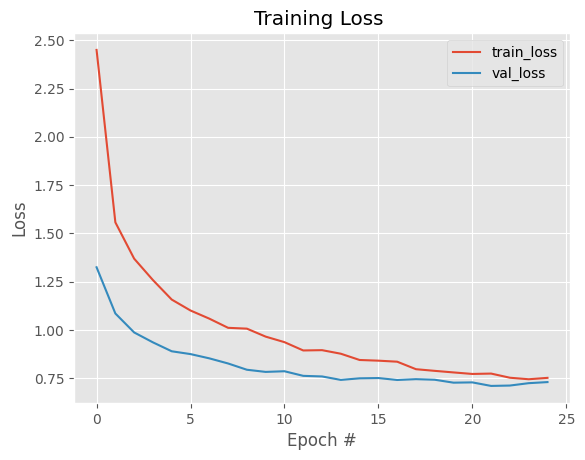

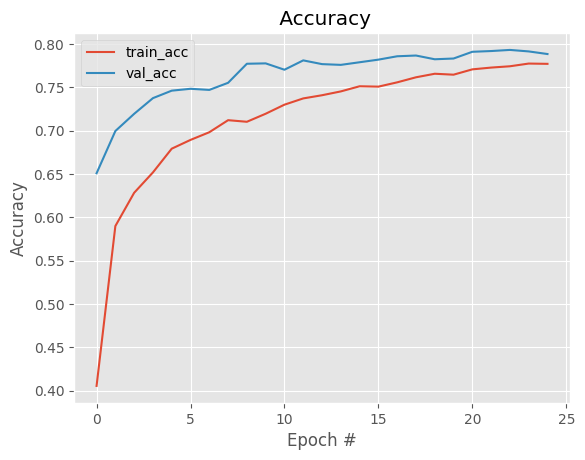

In [27]:
save_plot_loss(hist_effM, "thirtytwo_batch_size_512_loss_effM_2")
save_plot_acc(hist_effM,  "thirtytwo_batch_size_512_acc_effM_2")

In [29]:
"""
tuning batch size 16,32,64
"""

train_data_sixfour = image_dataset_from_directory(data_dir, image_size = (224,224), batch_size = 64, label_mode = 'categorical', validation_split=0.20,
                                        subset = 'training', seed=42)

val_data_sixfour = image_dataset_from_directory(data_dir, image_size = (224,224), batch_size = 64, label_mode = 'categorical', validation_split=0.20,
                                        subset = 'validation', seed=42)

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_data_sixfour = train_data_sixfour.prefetch(buffer_size=AUTOTUNE)

Found 11595 files belonging to 58 classes.
Using 9276 files for training.
Found 11595 files belonging to 58 classes.
Using 2319 files for validation.


In [30]:
start = time.time()
cbCheckpointBestM = tf.keras.callbacks.ModelCheckpoint(
        filepath='model_keras_tuner_batchNorm_512_32_EffM_64.{epoch:02d}-{val_loss:.2f}.keras',
        save_best_only=True,
        monitor="val_loss")

model_EffM_best = best_model_EffM()

hist_effM_64 = model_EffM_best.fit(train_data_sixfour, epochs=epochs, validation_data=val_data_sixfour, verbose=1, callbacks=[cbEvalAccM, cbCheckpointBestM])
# 0.8083
# 1024 -> 0.784 val_acc
# 512 -> 0.793
end = time.time()
print("The time of execution of above program is :",
      (end-start), "s")

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 img_augmentation (Sequenti  (None, None, None, 3)     0         
 al)                                                             
                                                                 
 efficientnetv2-m (Function  (None, None, None, 1280   53150388  
 al)                         )                                   
                                                                 
 global_average_pooling2d_4  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_8 (Dense)             (None, 512)               655872    
                                                           

min val_loss:  0.709933876991272
max val_accuracy:  0.7930142283439636


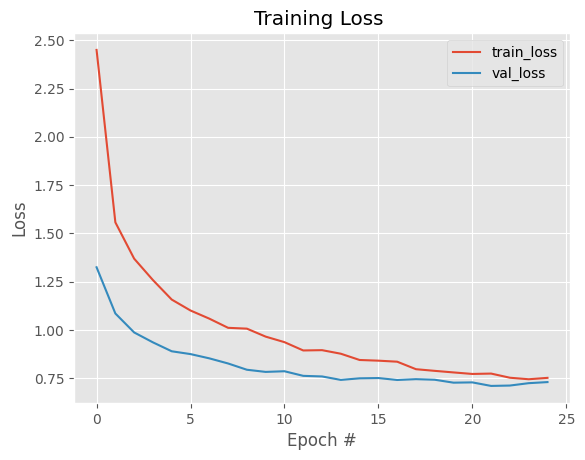

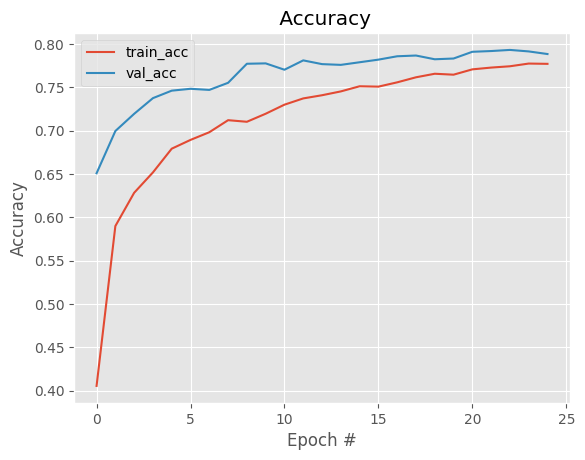

In [31]:
save_plot_loss(hist_effM, "thirtytwo_batch_size_512_loss_effM_3")
save_plot_acc(hist_effM,  "thirtytwo_batch_size_512_acc_effM_3")

In [50]:
epochs=50
learning_rate = 0.0005
decay_rate = learning_rate / 10 *  epochs

def exp_decay(epoch):
    lrate = learning_rate * np.exp(-decay_rate*epoch)
    return lrate

lr_rate = LearningRateScheduler(exp_decay)

In [52]:
start = time.time()
cbCheckpointBestM = tf.keras.callbacks.ModelCheckpoint(
        filepath='model_keras_tuner_batchNorm_512_32_EffM_64.{epoch:02d}-{val_loss:.2f}.keras',
        save_best_only=True,
        monitor="val_loss")

model_EffM_best = best_model_EffM()


hist_effM_32_dc = model_EffM_best.fit(train_data_thirtytwo, epochs=epochs, validation_data=val_data_thirtytwo, verbose=1, callbacks=[cbEvalAccM, cbCheckpointBestM, lr_rate])
# 0.8083
# 1024 -> 0.784 val_acc
# 512 -> 0.793
end = time.time()
print("The time of execution of above program is :",
      (end-start), "s")

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 img_augmentation (Sequenti  (None, None, None, 3)     0         
 al)                                                             
                                                                 
 efficientnetv2-m (Function  (None, None, None, 1280   53150388  
 al)                         )                                   
                                                                 
 global_average_pooling2d_5  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_10 (Dense)            (None, 512)               655872    
                                                           

min val_loss:  0.681835949420929
max val_accuracy:  0.8089693784713745


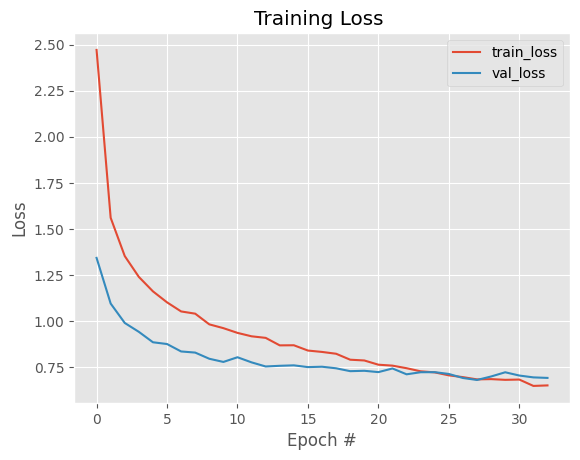

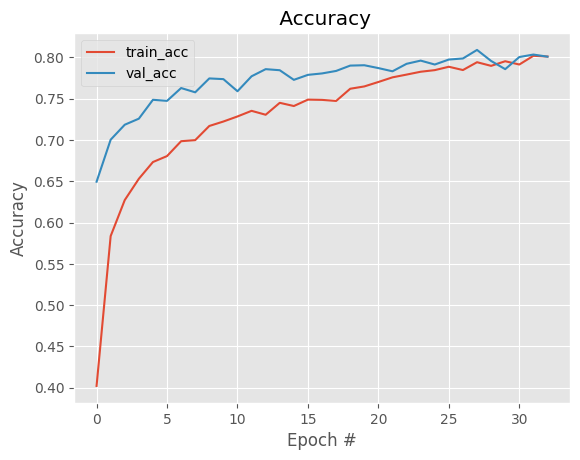

In [55]:
save_plot_loss(hist_effM_32_dc, "thirtytwo_batch_size_512_loss_effM_3")
save_plot_acc(hist_effM_32_dc,  "thirtytwo_batch_size_512_acc_effM_3")

In [56]:
epochs=50
learning_rate = 0.0005
decay_rate = learning_rate / 15 *  epochs

def exp_decay(epoch):
    lrate = learning_rate * np.exp(-decay_rate*epoch)
    return lrate

lr_rate = LearningRateScheduler(exp_decay)

In [57]:
start = time.time()
cbCheckpointBestM = tf.keras.callbacks.ModelCheckpoint(
        filepath='model_keras_tuner_batchNorm_512_32_EffM_64.{epoch:02d}-{val_loss:.2f}.keras',
        save_best_only=True,
        monitor="val_loss")

model_EffM_best = best_model_EffM()


hist_effM_32_dc = model_EffM_best.fit(train_data_thirtytwo, epochs=epochs, validation_data=val_data_thirtytwo, verbose=1, callbacks=[cbEvalAccM, cbCheckpointBestM, lr_rate])
# 0.8083
# 1024 -> 0.784 val_acc
# 512 -> 0.793
end = time.time()
print("The time of execution of above program is :",
      (end-start), "s")

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 img_augmentation (Sequenti  (None, None, None, 3)     0         
 al)                                                             
                                                                 
 efficientnetv2-m (Function  (None, None, None, 1280   53150388  
 al)                         )                                   
                                                                 
 global_average_pooling2d_6  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_12 (Dense)            (None, 512)               655872    
                                                           

min val_loss:  0.6836808323860168
max val_accuracy:  0.8106942772865295


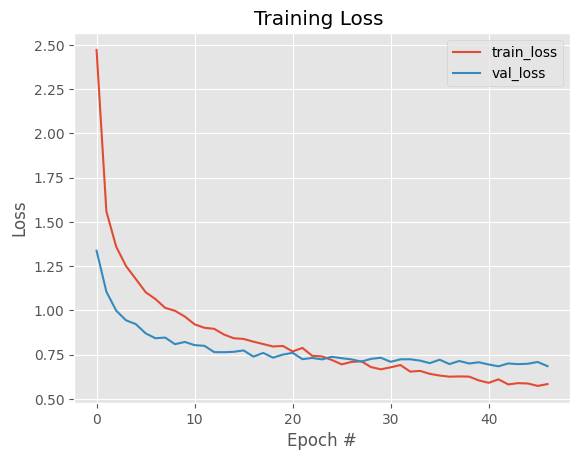

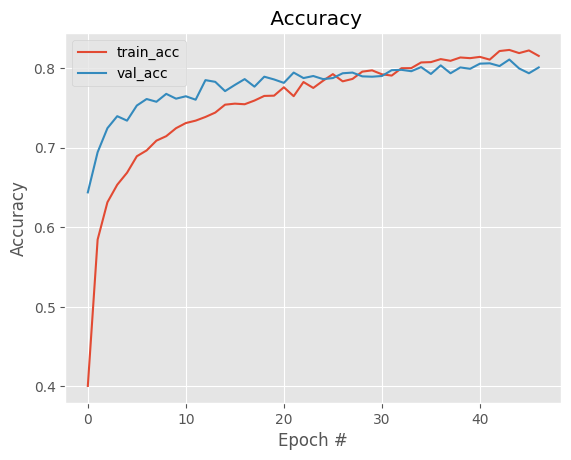

In [59]:
save_plot_loss(hist_effM_32_dc, "thirtytwo_batch_size_512_loss_effM_4")
save_plot_acc(hist_effM_32_dc,  "thirtytwo_batch_size_512_acc_effM_4")

In [67]:
from keras.regularizers import l2

cbEvalAccM =   tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=4,
    )


def best_model_EffM_16():
        inputs = base_model_M.input
        x = img_augmentation(inputs)

        x = base_model_M(x, training=False)

        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dense(units=512, activation='relu', kernel_regularizer=l2(0.0005))(x)
        x = tf.keras.layers.Dropout(0.3)(x)


        outputs =tf.keras.layers.Dense(58, activation='softmax')(x)
        model = tf.keras.Model(inputs, outputs)
        model.summary()

        model.compile(
            optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005),
            loss = tf.keras.losses.CategoricalCrossentropy(),
            metrics = ['accuracy']
        )
        return model

In [68]:
start = time.time()
cbCheckpointBestM = tf.keras.callbacks.ModelCheckpoint(
        filepath='model_keras_tuner_batchNorm_512_32_EffM_16.{epoch:02d}-{val_loss:.2f}.keras',
        save_best_only=True,
        monitor="val_loss")

model_EffM_best = best_model_EffM_16()


hist_effM_32_dc = model_EffM_best.fit(train_data_sixteen, epochs=epochs, validation_data=val_data_sixteen, verbose=1, callbacks=[cbEvalAccM, cbCheckpointBestM, lr_rate])
# 0.8083
# 1024 -> 0.784 val_acc
# 512 -> 0.793
end = time.time()
print("The time of execution of above program is :",
      (end-start), "s")

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 img_augmentation (Sequenti  (None, None, None, 3)     0         
 al)                                                             
                                                                 
 efficientnetv2-m (Function  (None, None, None, 1280   53150388  
 al)                         )                                   
                                                                 
 global_average_pooling2d_9  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_14 (Dense)            (None, 512)               655872    
                                                           

min val_loss:  1.1224870681762695
max val_accuracy:  0.7736093401908875


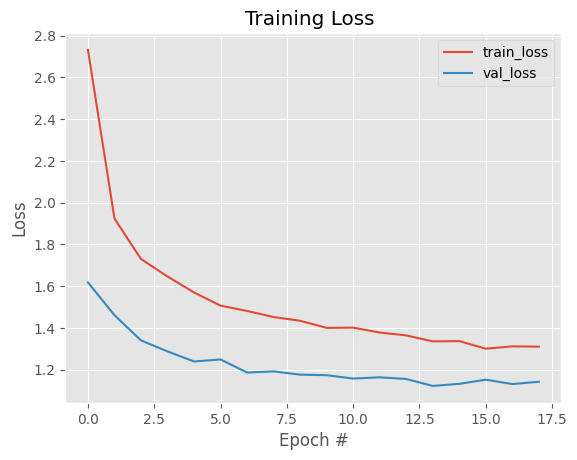

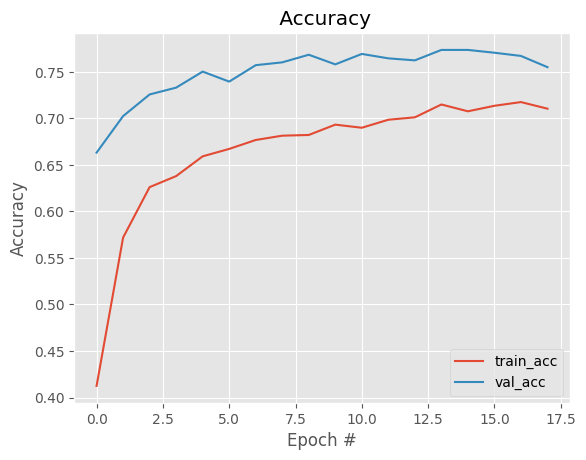

In [71]:
save_plot_loss(hist_effM_32_dc, "thirtytwo_batch_size_512_loss_effM_5")
save_plot_acc(hist_effM_32_dc,  "thirtytwo_batch_size_512_acc_effM_5")

In [73]:

cbEvalAccM =   tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=4,
    )


def best_model_EffM_16():
        inputs = base_model_M.input
        x = img_augmentation(inputs)

        x = base_model_M(x, training=False)

        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dense(units=512, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.3)(x)


        outputs =tf.keras.layers.Dense(58, activation='softmax')(x)
        model = tf.keras.Model(inputs, outputs)
        model.summary()

        model.compile(
            optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005),
            loss = tf.keras.losses.CategoricalCrossentropy(),
            metrics = ['accuracy']
        )
        return model

In [ ]:
start = time.time()
cbCheckpointBestM = tf.keras.callbacks.ModelCheckpoint(
        filepath='model_keras_tuner_batchNorm_512_32_EffM_16_2.{epoch:02d}-{val_loss:.2f}.keras',
        save_best_only=True,
        monitor="val_loss")

model_EffM_best = best_model_EffM_16()


hist_effM_16_dc = model_EffM_best.fit(train_data_sixteen, epochs=epochs, validation_data=val_data_sixteen, verbose=1, callbacks=[cbEvalAccM, cbCheckpointBestM, lr_rate])
# 0.8083
# 1024 -> 0.784 val_acc
# 512 -> 0.793
end = time.time()
print("The time of execution of above program is :",
      (end-start), "s")

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 img_augmentation (Sequenti  (None, None, None, 3)     0         
 al)                                                             
                                                                 
 efficientnetv2-m (Function  (None, None, None, 1280   53150388  
 al)                         )                                   
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
 0 (GlobalAveragePooling2D)                                      
                                                                 
 dense_16 (Dense)            (None, 512)               655872    
                                                           

save_plot_loss(hist_effM_32_dc, "thirtytwo_batch_size_512_loss_effM_5")
save_plot_acc(hist_effM_32_dc,  "thirtytwo_batch_size_512_acc_effM_5")

In [ ]:
# start = time.time()

# , kernel_regularizer=l2(0.0005)
# hist = model.fit(train_data, epochs=20, validation_data=val_data, verbose=1, callbacks=[cbEvalAcc, cbCheckpoint])

# end = time.time()
# print("The time of execution of above program is :",
#       (end-start), "s")

In [ ]:
acc = [0.] + hist.history['accuracy']
val_acc = [0.] + hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
results = model.evaluate(test_data, verbose=0)
print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

In [ ]:
allfoodNameDF =   pd.read_csv("allfoodName.csv")

foodLabels = allfoodNameDF.values.tolist()


In [ ]:
pred = model.predict(test_data)
pred = np.argmax(pred,axis=1)

# labels = (train_data.class_indices)
# labels = dict((v,k) for k,v in labels.items())
pred = [foodLabels[k] for k in pred]

print(f'The first 5 predictions: {pred[:5]}')

2024-09-16 05:03:08.841298: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-09-16 05:03:10.022899: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-09-16 05:03:10.022977: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB


1/1 [==============================] - 0s 59ms/step


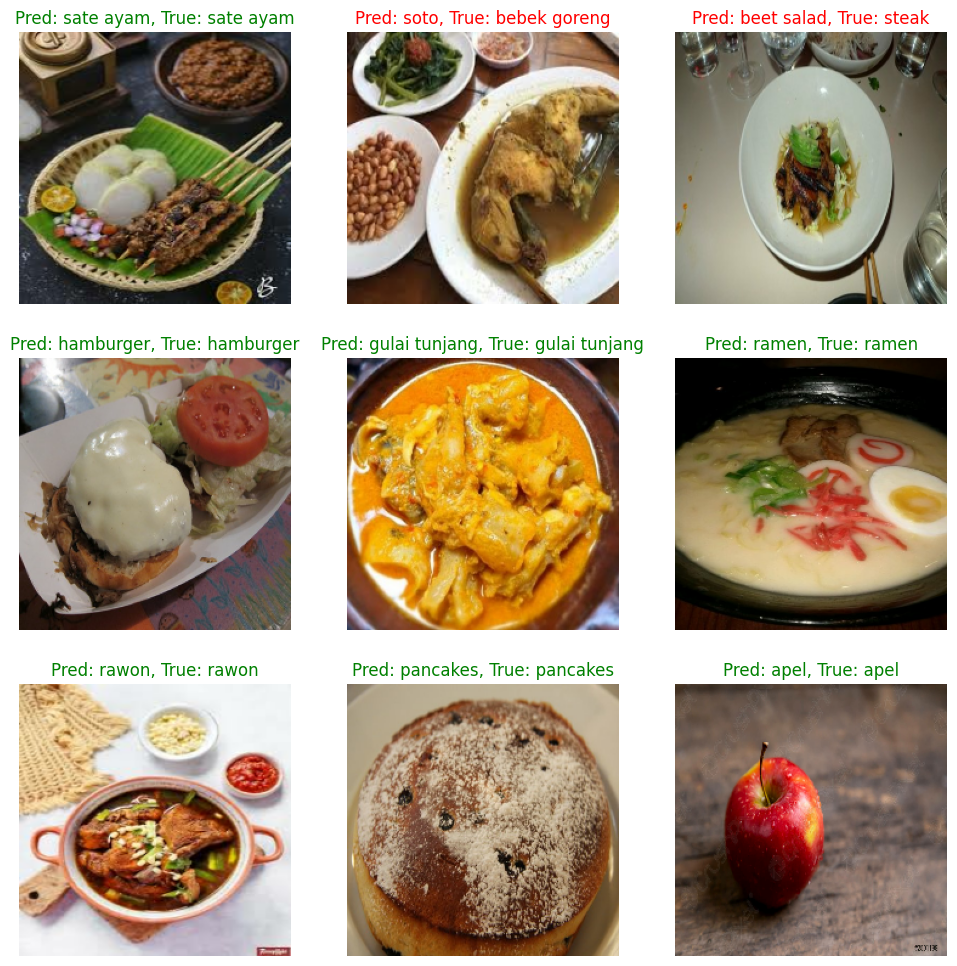

In [118]:


test_data = test_data.shuffle(buffer_size=1000)
pred
for images, labels in test_data.take(1):
    # Melakukan prediksi
    predictions = model.predict(images)
    
    # Mengambil kelas prediksi dan true label
    predicted_labels = tf.argmax(predictions, axis=1)
    true_labels = tf.argmax(labels, axis=1)
    color = ""
    
    

    # Menampilkan beberapa gambar, hasil prediksi, dan true label
    plt.figure(figsize=(12, 12))
    for i in range(9):  # Menampilkan 9 gambar pertama
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        if foodLabels[predicted_labels[i]][1] ==  foodLabels[true_labels[i]][1]:
            color = "green"
        else:
            color = "red"
        plt.title(f"Pred: {foodLabels[predicted_labels[i]][1]}, True: {foodLabels[true_labels[i]][1]}" , color=color)
        plt.axis("off")

    plt.show()

In [119]:
y_test = list(foodLabels)
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df


ValueError: Found input variables with inconsistent numbers of samples: [58, 752]

In [83]:
import pickle

model.save('indofood_nutrition_512_batchNorm_10epochs.keras')

In [56]:
model_ten_epochs = tf.keras.models.load_model('indofood_nutrition_512_batchNorm_10epochs.keras')

In [57]:
start = time.time()

hist_twenty_epochs = model_ten_epochs.fit(train_data, epochs=10, validation_data=val_data, verbose=1, callbacks=[cbEvalAcc, cbCheckpoint])

end = time.time()
print("The time of execution of above program is :",
      (end-start) , "s")

Epoch 1/10
100/267 [==========>...................] - ETA: 15s - loss: 0.7524 - accuracy: 0.7725

2024-09-16 03:49:13.290447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


152/267 [================>.............] - ETA: 10s - loss: 0.7642 - accuracy: 0.7749

2024-09-16 03:49:18.031324: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


247/267 [==========================>...] - ETA: 1s - loss: 0.7542 - accuracy: 0.7786

2024-09-16 03:49:26.855144: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


267/267 [==============================] - 48s 131ms/step - loss: 0.7493 - accuracy: 0.7805 - val_loss: 0.6753 - val_accuracy: 0.7982
Epoch 2/10
101/267 [==========>...................] - ETA: 15s - loss: 0.7217 - accuracy: 0.7831

2024-09-16 03:49:53.925584: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


153/267 [================>.............] - ETA: 10s - loss: 0.7309 - accuracy: 0.7843

2024-09-16 03:49:58.795198: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


243/267 [==========================>...] - ETA: 2s - loss: 0.7297 - accuracy: 0.7827

2024-09-16 03:50:07.356673: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


267/267 [==============================] - 32s 118ms/step - loss: 0.7300 - accuracy: 0.7828 - val_loss: 0.6782 - val_accuracy: 0.8001
Epoch 3/10
101/267 [==========>...................] - ETA: 15s - loss: 0.6861 - accuracy: 0.7939

2024-09-16 03:50:26.020787: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


154/267 [================>.............] - ETA: 10s - loss: 0.6877 - accuracy: 0.7940

2024-09-16 03:50:31.056258: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


244/267 [==========================>...] - ETA: 2s - loss: 0.6969 - accuracy: 0.7935

2024-09-16 03:50:39.584884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


267/267 [==============================] - 32s 120ms/step - loss: 0.6960 - accuracy: 0.7944 - val_loss: 0.6794 - val_accuracy: 0.8020
Epoch 4/10
100/267 [==========>...................] - ETA: 15s - loss: 0.6493 - accuracy: 0.7987

2024-09-16 03:50:58.227534: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


152/267 [================>.............] - ETA: 10s - loss: 0.6467 - accuracy: 0.7983

2024-09-16 03:51:03.071454: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


247/267 [==========================>...] - ETA: 1s - loss: 0.6613 - accuracy: 0.7948

2024-09-16 03:51:11.955566: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


267/267 [==============================] - 32s 118ms/step - loss: 0.6650 - accuracy: 0.7956 - val_loss: 0.6841 - val_accuracy: 0.8015
Epoch 5/10
101/267 [==========>...................] - ETA: 15s - loss: 0.6515 - accuracy: 0.8041

2024-09-16 03:51:29.859942: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


153/267 [================>.............] - ETA: 10s - loss: 0.6514 - accuracy: 0.7998

2024-09-16 03:51:34.867175: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


248/267 [==========================>...] - ETA: 1s - loss: 0.6597 - accuracy: 0.8009

2024-09-16 03:51:43.862233: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


267/267 [==============================] - 33s 121ms/step - loss: 0.6608 - accuracy: 0.8007 - val_loss: 0.6593 - val_accuracy: 0.8095
Epoch 6/10
100/267 [==========>...................] - ETA: 15s - loss: 0.6340 - accuracy: 0.8022

2024-09-16 03:52:02.569364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


152/267 [================>.............] - ETA: 10s - loss: 0.6347 - accuracy: 0.8010

2024-09-16 03:52:07.546278: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


247/267 [==========================>...] - ETA: 1s - loss: 0.6394 - accuracy: 0.8036

2024-09-16 03:52:16.601663: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


267/267 [==============================] - 32s 119ms/step - loss: 0.6350 - accuracy: 0.8027 - val_loss: 0.6889 - val_accuracy: 0.8015
Epoch 7/10
101/267 [==========>...................] - ETA: 15s - loss: 0.6041 - accuracy: 0.8128

2024-09-16 03:52:34.725874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


153/267 [================>.............] - ETA: 10s - loss: 0.6064 - accuracy: 0.8154

2024-09-16 03:52:39.659651: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


243/267 [==========================>...] - ETA: 2s - loss: 0.6049 - accuracy: 0.8139

2024-09-16 03:52:48.347259: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


267/267 [==============================] - 32s 119ms/step - loss: 0.6004 - accuracy: 0.8155 - val_loss: 0.6737 - val_accuracy: 0.8053
Epoch 8/10
101/267 [==========>...................] - ETA: 15s - loss: 0.5623 - accuracy: 0.8270

2024-09-16 03:53:06.841529: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


153/267 [================>.............] - ETA: 10s - loss: 0.5605 - accuracy: 0.8274

2024-09-16 03:53:11.874157: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


248/267 [==========================>...] - ETA: 1s - loss: 0.5678 - accuracy: 0.8245

2024-09-16 03:53:20.961266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


267/267 [==============================] - 32s 119ms/step - loss: 0.5791 - accuracy: 0.8223 - val_loss: 0.6621 - val_accuracy: 0.8104
Epoch 9/10
101/267 [==========>...................] - ETA: 15s - loss: 0.5596 - accuracy: 0.8264

2024-09-16 03:53:38.901537: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


152/267 [================>.............] - ETA: 10s - loss: 0.5617 - accuracy: 0.8246

2024-09-16 03:53:43.924981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


248/267 [==========================>...] - ETA: 1s - loss: 0.5729 - accuracy: 0.8231

2024-09-16 03:53:52.956547: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


267/267 [==============================] - 33s 121ms/step - loss: 0.5745 - accuracy: 0.8232 - val_loss: 0.6410 - val_accuracy: 0.8142
Epoch 10/10
101/267 [==========>...................] - ETA: 15s - loss: 0.5518 - accuracy: 0.8301

2024-09-16 03:54:19.951043: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


155/267 [================>.............] - ETA: 10s - loss: 0.5520 - accuracy: 0.8298

2024-09-16 03:54:25.242610: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


243/267 [==========================>...] - ETA: 2s - loss: 0.5502 - accuracy: 0.8292

2024-09-16 03:54:33.521004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


267/267 [==============================] - 32s 119ms/step - loss: 0.5514 - accuracy: 0.8280 - val_loss: 0.6637 - val_accuracy: 0.8067
The time of execution of above program is : 350.95152020454407 s


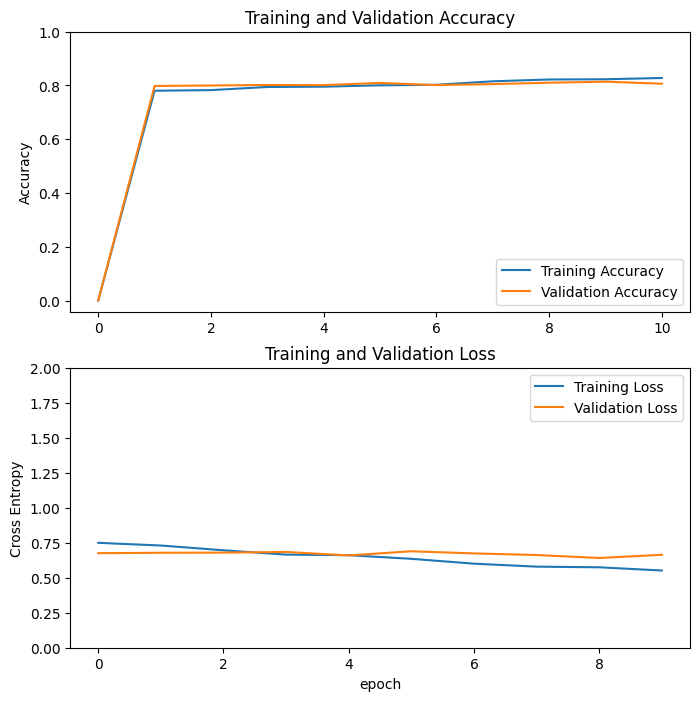

In [59]:
acc = [0.] + hist_twenty_epochs.history['accuracy']
val_acc = [0.] + hist_twenty_epochs.history['val_accuracy']

loss = hist_twenty_epochs.history['loss']
val_loss = hist_twenty_epochs.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# modelFromDisk_indofood1.save('indofood_nutritionv2_2.keras')

In [ ]:
# modelFromDisk_indofood2 = tf.keras.models.load_model('indofood_nutrition_2.keras')

In [8]:
# modelFromDisk_indofood2.evaluate(val_data, steps=16)

In [9]:
df2 = pd.read_csv("allfoodName.csv")

labels = df2.values.tolist()

FileNotFoundError: [Errno 2] No such file or directory: 'allfoodName.csv'

In [ ]:

def decode_jpeg_and_label_disk_model3(filename: str) -> list[any]:
  image = Image.open(filename)
  image.show()
  image = image.resize((224, 224))
  tt = np.array(image)
  tt = np.expand_dims(tt, axis=0)
  prediction = model.predict(tt)
  sorted_categories = np.argsort(prediction[0])[:-65:-1]    # terbesar ke terkecil

  prob = np.sort(prediction)
  cats = []
  i = 0
  prob = prob[0][:-65:-1]


  for predCat in sorted_categories:
      if prob[i] > 0.15:
          cats.append(labels[predCat])
      i +=1
  if len(cats) == 0:
      return [labels[tf.argmax(prediction[0])]]
  return cats

In [ ]:
bakso = decode_jpeg_and_label_disk_model3('bakso.jpg')[0][1]
bakso

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


'bakso'

In [ ]:
indofood_nutritions_df = pd.read_csv("indofood_with_its_nutritions.csv")

In [ ]:
def getFoodNutrition(foodName: str):
    foodName = foodName.lower()
    myFoodNutrition = {}
    for  idx, food  in indofood_nutritions_df.iterrows():
        if foodName == food["food_name"]:
            myFoodNutrition["calories"] = food["calories"]
            myFoodNutrition["fat"] = food["fat"]
            myFoodNutrition["carbohydrate"] = food["carbohydrate"]
            myFoodNutrition["proteins"] = food["proteins"]
    return myFoodNutrition


In [ ]:
getFoodNutrition(bakso)

{'calories': '144.7', 'fat': '4.5', 'carbohydrate': '14.3', 'proteins': '12.1'}

In [ ]:
ayamgoreng = decode_jpeg_and_label_disk_model3('ayamgoreng3.jpg')[0][1]
ayamgoreng

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


'ayam goreng'

In [ ]:
getFoodNutrition(ayamgoreng)

{'calories': '302', 'fat': '25', 'carbohydrate': '0', 'proteins': '18.2'}

In [ ]:
sate = decode_jpeg_and_label_disk_model3('sate_madura.jpg')[0][1]
sate

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


'sate ayam'

In [ ]:
getFoodNutrition(sate)

{'calories': '110', 'fat': '0.5', 'carbohydrate': '11.5', 'proteins': '15.5'}